In [ ]:
import torch  # Go to readme for instructions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

c:\Users\S.SHIKHAR\Desktop\New Hybrid\myvenvv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------------------
# Load & Prepare Data
# ------------------------------
df = pd.read_csv("random_augmented_balanced_dataset.csv")
df.dropna(inplace=True)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# BoW (Bag-of-Words)
bow_vectorizer = CountVectorizer(max_features=400)
bow_features = bow_vectorizer.fit_transform(df['text']).toarray()

# POS Tags
nlp = spacy.load("en_core_web_md")
pos_tags = []
for doc in nlp.pipe(df['text'].tolist(), batch_size=64):
    counts = doc.count_by(spacy.attrs.POS)
    vec = np.array([counts.get(i, 0) for i in range(len(nlp.vocab))])[:100]
    pos_tags.append(vec)
pos_tags = np.array(pos_tags)

shallow_features = np.concatenate([bow_features, pos_tags], axis=1)
shallow_dim = shallow_features.shape[1]

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Split 80/10/10
X_train, X_temp, sf_train, sf_temp, y_train, y_temp = train_test_split(
    df['text'], shallow_features, df['label'], test_size=0.2, random_state=42)
X_val, X_test, sf_val, sf_test, y_val, y_test = train_test_split(
    X_temp, sf_temp, y_temp, test_size=0.5, random_state=42)

train_df = pd.DataFrame({'label': y_train})

# ------------------------------
# Dataset
# ------------------------------
class IntentDataset(Dataset):
    def __init__(self, texts, shallow_feats, labels, tokenizer, max_len=192):
        self.texts = texts.tolist()
        self.shallow_feats = shallow_feats
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding='max_length', truncation=True,
            max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'shallow_feats': torch.tensor(self.shallow_feats[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# ------------------------------
# Model
# ------------------------------
class HybridIntentClassifier(nn.Module):
    def __init__(self, shallow_dim, hidden_dim, num_classes, dropout):
        super().__init__()
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1", trust_remote_code=True, use_safetensors=True)
        self.shallow_proj = nn.Linear(shallow_dim, hidden_dim)
        self.deep_proj = nn.Linear(768, hidden_dim)
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes))

    def forward(self, shallow_feats, input_ids, attn_mask):
        deep_out = self.bert(input_ids=input_ids, attention_mask=attn_mask).last_hidden_state[:, 0, :]
        proj_shallow = self.shallow_proj(shallow_feats).unsqueeze(1)
        proj_deep = self.deep_proj(deep_out).unsqueeze(1)
        attn_out, _ = self.cross_attention(query=proj_shallow, key=proj_deep, value=proj_deep)
        return self.classifier(attn_out.squeeze(1))

# ------------------------------
# Train Prep
# ------------------------------
train_set = IntentDataset(X_train, sf_train, y_train, tokenizer)
val_set = IntentDataset(X_val, sf_val, y_val, tokenizer)
test_set = IntentDataset(X_test, sf_test, y_test, tokenizer)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

model = HybridIntentClassifier(shallow_dim, 512, 10, 0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
boost_labels = ["treatment", "treatment method", "symptoms", "disease manifestations"]
boost_indices = label_encoder.transform(boost_labels)
for idx in boost_indices:
    class_weights_tensor[idx] *= 1.0  # tune this factor

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.05 * len(train_loader) * 10), num_training_steps=len(train_loader) * 10)

Epoch 1 | Train Loss: 1.7847 | Val Loss: 1.3961 | Val Acc: 0.4877
Epoch 2 | Train Loss: 1.1976 | Val Loss: 1.1001 | Val Acc: 0.5906
Epoch 3 | Train Loss: 0.8734 | Val Loss: 1.0484 | Val Acc: 0.6344
Epoch 4 | Train Loss: 0.6246 | Val Loss: 0.9309 | Val Acc: 0.6894
Epoch 5 | Train Loss: 0.4465 | Val Loss: 0.9242 | Val Acc: 0.7253
Epoch 6 | Train Loss: 0.3180 | Val Loss: 0.9523 | Val Acc: 0.7478
Epoch 7 | Train Loss: 0.2209 | Val Loss: 0.9845 | Val Acc: 0.7790
Epoch 8 | Train Loss: 0.1461 | Val Loss: 1.1359 | Val Acc: 0.7784
Early stopping.


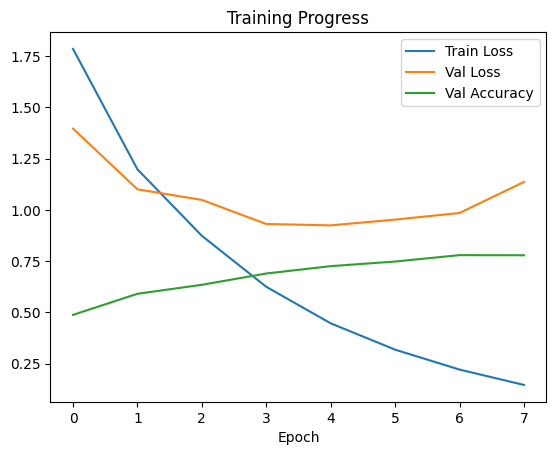

In [3]:
# ------------------------------
# Train Function
# ------------------------------
def train_model(model, train_loader, val_loader):
    best_loss = float('inf')
    best_model = None
    patience = 3
    counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(10):
        model.train()
        train_losses = []
        for batch in train_loader:
            ids, mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            shallow, labels = batch['shallow_feats'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(shallow, ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses, preds, targets = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                ids, mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
                shallow, labels = batch['shallow_feats'].to(device), batch['labels'].to(device)
                outputs = model(shallow, ids, mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                targets.extend(labels.cpu().numpy())

        val_loss = np.mean(val_losses)
        val_acc = accuracy_score(targets, preds)
        print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_model)
    return model, history

model, history = train_model(model, train_loader, val_loader)

# ------------------------------
# Plot Training History
# ------------------------------
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [4]:
# ------------------------------
# Final Test Evaluation
# ------------------------------
def evaluate_model(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            shallow = batch['shallow_feats'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(shallow, ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    print(classification_report(targets, preds, digits=4, target_names=label_encoder.classes_))
    print("Test Accuracy:", accuracy_score(targets, preds))

evaluate_model(model, test_loader)

                        precision    recall  f1-score   support

    applicable disease     0.9375    0.8654    0.9000       156
              ask more     0.7262    0.8592    0.7871       142
                 cause     0.7679    0.8165    0.7914       158
            definition     0.9412    0.8780    0.9085       164
disease manifestations     0.7073    0.6905    0.6988       126
                method     0.8267    0.7654    0.7949       162
              symptoms     0.7477    0.6336    0.6860       131
             treatment     0.5094    0.7200    0.5967       150
      treatment method     0.7886    0.5988    0.6807       162
                 usage     0.9487    0.9427    0.9457       157

              accuracy                         0.7805      1508
             macro avg     0.7901    0.7770    0.7790      1508
          weighted avg     0.7952    0.7805    0.7832      1508

Test Accuracy: 0.7805039787798409
